### Overview

Several important terms in the topic of CUDA programming are listed here:
- host: the CPU
- device: the GPU
- host memory: the system main memory
- device memory: onboard memory on a GPU card
- kernels: a GPU function launched by the host and executed on the device
- device function: a GPU function executed on the device which can only be called from the device (i.e. from a kernel or another device function)

CUDA has an execution model unlike the traditional sequential model used for programming CPUs. In CUDA, the code you write will be executed by multiple threads at once (often hundreds or thousands). Your solution will be modeled by defining a thread hierarchy of **grid**, **blocks** and **threads**.

Numba also exposes three kinds of GPU memory:
- global device memory (the large, relatively slow off-chip memory that’s connected to the GPU itself),
- on-chip shared memory,
- local memory.

### Kernel declaration

A kernel function is a GPU function that is meant to be called from CPU code. It gives it two fundamental characteristics:  
- kernels cannot explicitly return a value; all result data must be written to an array passed to the function,
- kernels explicitly declare their thread hierarchy when called: i.e. the number of thread blocks and the number of threads per block.

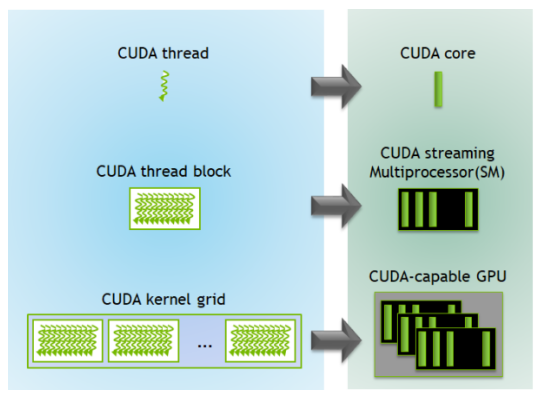

- Each CUDA block is executed by one streaming multiprocessor (SM) and cannot be migrated to other SMs in GPU.  
- One SM can run several concurrent CUDA blocks depending on the resources needed by CUDA blocks.  
- Each kernel is executed on one device and CUDA supports running multiple kernels on a device at one time. 

A kernel is typically launched in the following way:

In [89]:
import numpy as np
from numba import cuda 

@cuda.jit
def increment_by_one(an_array):
    # Thread id in a 1D block
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    ty = cuda.blockIdx.x
    # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    # Compute flattened index inside the array
    pos = tx + ty * bw
    if pos < an_array.size:  # Check array boundaries
        an_array[pos] += 1

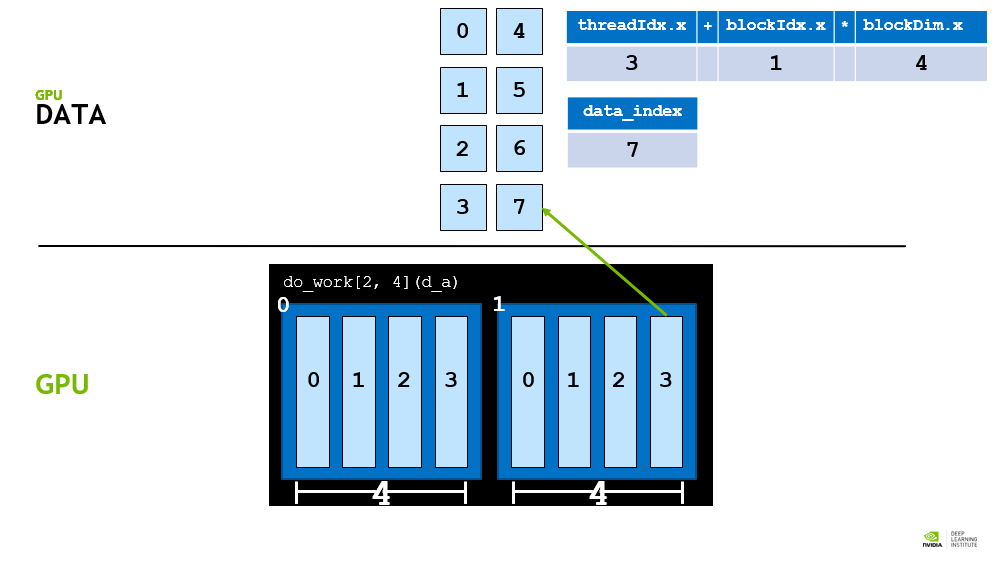

In [95]:
an_array = np.arange(8)

In [96]:
an_array

array([0, 1, 2, 3, 4, 5, 6, 7])

In [69]:
an_array.size 

8

In [91]:
threadsperblock = 4
blockspergrid = (an_array.size + (threadsperblock - 1)) //  threadsperblock

In [92]:
threadsperblock

4

In [93]:
blockspergrid 

2

In [106]:
device_array = cuda.to_device(an_array)

increment_by_one[blockspergrid, threadsperblock](device_array)

result_array = device_array.copy_to_host()

In [107]:
result_array

array([1, 2, 3, 4, 5, 6, 7, 8])

In [108]:
%timeit increment_by_one[blockspergrid, threadsperblock](device_array)

25.7 µs ± 2.39 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Check performance